## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log, ceil
import os
import pickle
import sys

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

In [2]:
%matplotlib inline

### load the dataset

In [3]:
### set your image dir here
IMAGE_DIR = "./data/"

In [4]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [5]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [6]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./data/train/1.png


/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


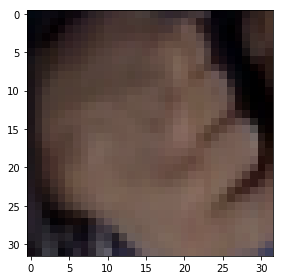

In [7]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [8]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        
        return self.__wt,self.__bias
        
    def loss(self, y, X):
        n = len(y)
        h = np.dot(X, self.__wt) + self.__bias
        
        return (-1/n)*(np.dot(np.transpose(y), h) - np.sum(np.log(1 + np.exp(h))))
                
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__init_param()
        
        ### write your code here ### 

        ############################
        
        y = np.reshape(y, (len(y), 1))
        
        if y_val is not None:
            y_val = np.reshape(y_val, (len(y_val), 1))
        
        X_ones = np.hstack((X, np.ones(n).reshape(n, 1)))
                
        wt = self.__wt
        wt = np.reshape(np.append(wt, self.__bias), (d + 1, 1))
        
        epoch_loss = []
        epoch_loss_val = []
        
        accuracy = []
        accuracy_val = []
        
        for epoch in range(1, self.__max_epoch + 1):            
            eta = self.__eta0 / (self.__eta1 + epoch)
            
            idx_arr = np.arange(n)
            idx_arr = np.random.permutation(idx_arr)
            
            batches = np.array_split(idx_arr, ceil((n*1.0)/self.__m))
            
            for batch in batches:
                y_batch = y[batch]
                X_batch = X_ones[batch,:]
                
                h = self.sigmoid(np.dot(X_batch, wt))
                
                derivative = np.dot(np.transpose(X_batch), (y_batch - h)) / len(batch)

                wt = wt + (eta * derivative)
                            
            self.__wt = wt[:-1]
            self.__bias = wt[-1]
            
            epoch_loss.append(self.loss(y, X).item(0, 0))                    
            accuracy.append(self.accuracy(y, self.predict(X)))
            
            if X_val is not None:
                epoch_loss_val.append(self.loss(y_val, X_val).item(0))
                accuracy_val.append(self.accuracy(y_val, self.predict(X_val)))
            
            if epoch > 1 and epoch_loss[epoch - 1] > (1 - self.__delta) * epoch_loss[epoch - 2]:
                break
        
        return epoch, epoch_loss, epoch_loss_val, accuracy, accuracy_val
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
                        
        return self.sigmoid(np.dot(X, self.__wt) + self.__bias)
    
    def predict(self, X):
        """
        Classify the sample
        """

        return self.predict_proba(X) >= 0.5
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)
            
    def accuracy(self, y, y_pred):
        if len(y) != len(y_pred):
            raise ValueError('y and y_pred should have same size')
        
        #return np.sum((y == y_pred) / len(y)) * 100
        return accuracy_score(y, y_pred)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

In [9]:
LR = LogisticRegression()
epoch, epoch_loss, _, accuracy, _ = LR.fit(X_train, y_train, X_val, y_val)

print("Epoch: %d" % (epoch))
print("Final L(theta): %f" % (epoch_loss[-1]))

Epoch: 348
Final L(theta): 0.513332


(a) Number of epochs till termination = 348

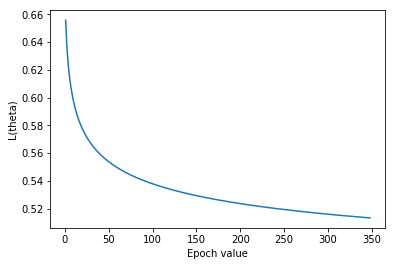

In [10]:
# (b) Plot L(theta) vs num_epochs
plt.plot(np.arange(epoch) + 1, epoch_loss)
plt.xlabel('Epoch value')
plt.ylabel('L(theta)')
plt.show()

(c) Final value of L($\theta$) after optimization = 0.513332

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [30]:
# Experimentation code goes here
eta0_list = [10, 5, 1, 0.5, 0.1, 0.05, 0.01]
eta1_list = [10, 5, 1, 0.5, 0.1, 0.05, 0.01]

min_epoch = sys.maxsize
min_epoch_loss = [sys.maxsize]
best_eta0 = sys.maxsize
best_eta1 = sys.maxsize

for eta0 in eta0_list:
    for eta1 in eta1_list:
        LR = LogisticRegression(eta0 = eta0, eta1 = eta1)
        epoch, loss, _, accuracy, _ = LR.fit(X_train, y_train)

        print("eta0: %f eta1: %f epoch: %d L: %f acurracy: %f" % (eta0, eta1, epoch, loss[-1], accuracy[-1]))
        
        if min_epoch > epoch:
            min_epoch = epoch
            min_epoch_loss = loss
            best_eta0 = eta0
            best_eta1 = eta1

eta0: 10.000000 eta1: 10.000000 epoch: 16 L: 0.309245 acurracy: 0.868788
eta0: 10.000000 eta1: 5.000000 epoch: 21 L: 0.290944 acurracy: 0.887882
eta0: 10.000000 eta1: 1.000000 epoch: 9 L: 0.282127 acurracy: 0.889963
eta0: 10.000000 eta1: 0.500000 epoch: 11 L: 0.275830 acurracy: 0.892166
eta0: 10.000000 eta1: 0.100000 epoch: 11 L: 0.272487 acurracy: 0.889718
eta0: 10.000000 eta1: 0.050000 epoch: 4 L: 0.285211 acurracy: 0.886536
eta0: 10.000000 eta1: 0.010000 epoch: 5 L: 0.287514 acurracy: 0.876255
eta0: 5.000000 eta1: 10.000000 epoch: 51 L: 0.307055 acurracy: 0.878213
eta0: 5.000000 eta1: 5.000000 epoch: 24 L: 0.307579 acurracy: 0.881028
eta0: 5.000000 eta1: 1.000000 epoch: 15 L: 0.297123 acurracy: 0.886169
eta0: 5.000000 eta1: 0.500000 epoch: 6 L: 0.309374 acurracy: 0.883966
eta0: 5.000000 eta1: 0.100000 epoch: 3 L: 0.337449 acurracy: 0.863770
eta0: 5.000000 eta1: 0.050000 epoch: 10 L: 0.290464 acurracy: 0.888862
eta0: 5.000000 eta1: 0.010000 epoch: 8 L: 0.295564 acurracy: 0.878703
eta

In [27]:
print("Min Epoch: %d\nLoss: %f\nBest eta0: %f\nBest eta1: %f" % (min_epoch, min_epoch_loss[-1], best_eta0, best_eta1))

Min Epoch: 4
Loss: 0.290057
Best eta0: 10.000000
Best eta1: 0.500000


(a) Best value for, $\eta_0$ = 10, $\eta_1$ = 0.5

Number of epochs for training = 4

Final value of L($\theta$) = 0.290057

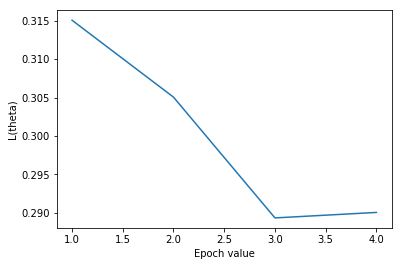

In [28]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
plt.plot(np.arange(min_epoch) + 1, min_epoch_loss)
plt.xlabel('Epoch value')
plt.ylabel('L(theta)')
plt.show()

### 3. Evaluating on validation set

In [14]:
LR_val = LogisticRegression()
epoch, epoch_loss, epoch_loss_val, accuracy, accuracy_val = LR_val.fit(X_train, y_train, X_val, y_val)

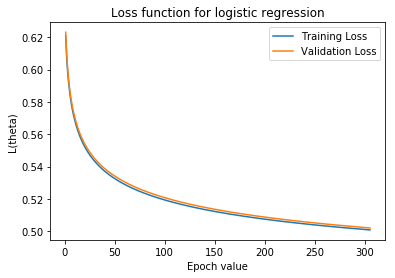

In [15]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure
plt.plot(np.arange(epoch) + 1, epoch_loss)
plt.plot(np.arange(epoch) + 1, epoch_loss_val)

plt.title("Loss function for logistic regression")
plt.xlabel("Epoch value")
plt.ylabel("L(theta)")
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper right')

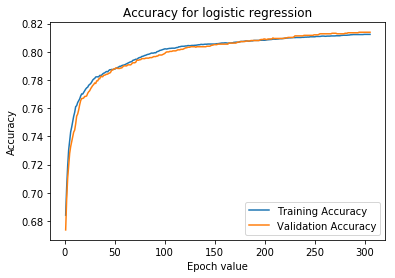

In [16]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
plt.plot(np.arange(epoch) + 1, accuracy)
plt.plot(np.arange(epoch) + 1, accuracy_val)

plt.title("Accuracy for logistic regression")
plt.xlabel("Epoch value")
plt.ylabel("Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc = 'lower right')
plt.show()

### 4. ROC and Precision-Recall curves

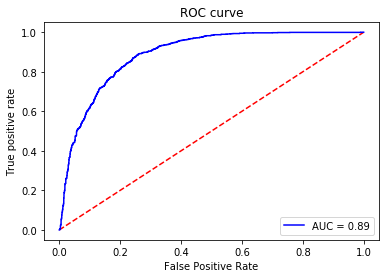

In [17]:
#(a) Plot ROC curve on validation data
fpr, tpr, _ = roc_curve(y_val, LR_val.predict_proba(X_val))
roc_auc = auc(fpr, tpr)

# Referred: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot([0, 1], [0, 1],'r--')
plt.step(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True positive rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show()

Area under curve = 0.89

Text(0,0.5,'Precision')

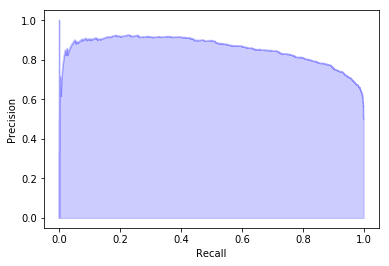

In [18]:
#(a) Plot Precision-Recall curve on validation data
precision, recall, thresholds = precision_recall_curve(y_val, LR_val.predict_proba(X_val))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')

In [29]:
average_precision_score(y_val, LR_val.predict_proba(X_val))

0.8553070647559913

In [21]:
Average Precision = 0.855307

SyntaxError: invalid syntax (<ipython-input-21-43e65e942708>, line 1)

## Question 2.4

### 1. Submission

In [22]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [23]:
# code goes here
LR = LogisticRegression(eta0 = 10, eta1 = 0.01, m = 4)
epoch, epoch_loss, _, accuracy, _ = LR.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print("Epoch Loss: %f" % (epoch_loss[-1]))
print("Accuracy: %f" % (accuracy[-1]))

submission(LR.predict(X_test).astype(int))

Epoch Loss: 0.294471
Accuracy: 0.877639


Best obtained accuracy on Public Leader-board = 88.704%